In [1]:
import numpy as np

from util import *
from Algorithm.graph import *
from Algorithm.distribution import *
from IO.read_10X import *

In [2]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
#adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
#adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
#adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

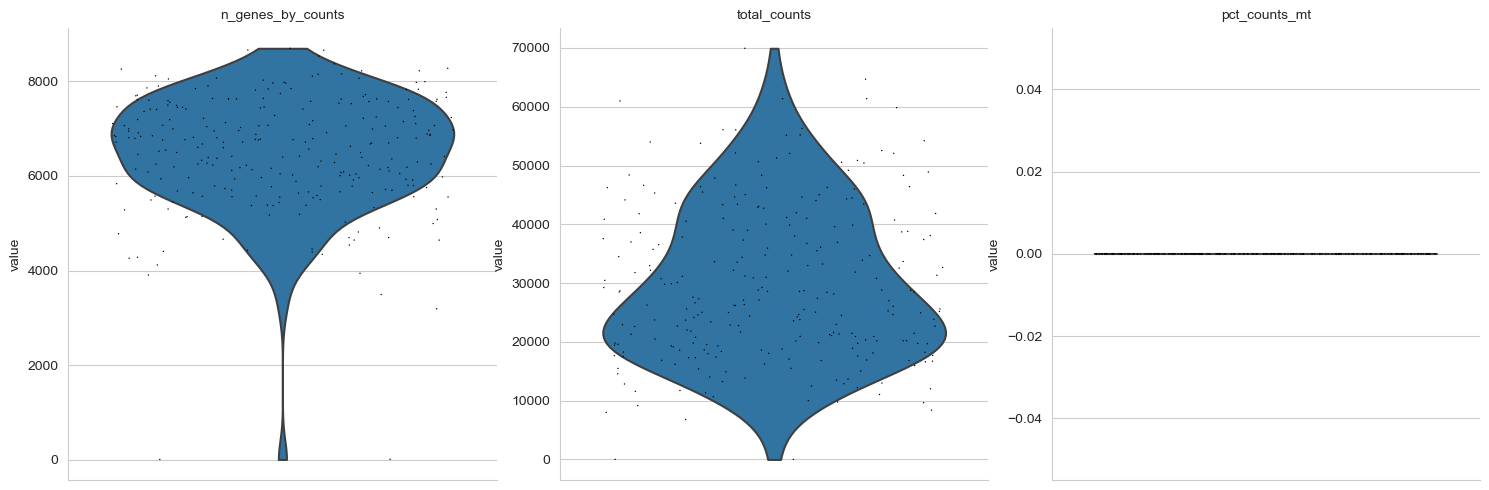

In [2]:
h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = read_10X_h5ad('F://Rep11_MOB_ST.h5ad', amplification=1000)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

In [4]:
gene_list = adata.var[adata.var['highly_variable']==True].index
len(gene_list)

2206

In [5]:
gene_list = list(adata.var.index)
len(gene_list)

9868

In [4]:
paper = ['Rab3b','Necab2','Tspan7','Cdr1','Slc17a7','4933405L10Rik','Taf7l','Gna14','Olfr635','Pmepa1','Pcp4','Apc','Rbfox3','Penk','Frzb','Fabp7','Slc6a11','Apod','S100a5','Arhgap33','Cplx1','Trnp1','Marcks','Atp1b1','Vtn','Trak2','Igf1','Gabra1','Igfbp2','Lpar1','Omp','Kif5b','Sorbs1','Cck','Nr2f2','Scd1','Cpe','Aqp4','Doc2g','Slc1a2','Nrgn','Cdhr1','Mcf2l','Kctd12','Unc13c','Foxd3','Prokr2','Gng13','Kcnh3','Camk2b','Baiap2','Ccnd1','Gpsm1','Pbx1','Sepp1','Apoe','Tubb2b','Ncdn','Glul','Sash1','Ptgds','Sparcl1','Mbp','Nrsn1','Igfbp5','Ptn','Sfrp5']
gene_list = adata.var[adata.var['gene_ids'].isin(paper)].index
len(gene_list)

62

In [28]:
gmm_dict = fit_gmms(adata, gene_list, n_comp=20, n_top_comp=20)

Processing ...: 100%|██████████| 62/62 [02:24<00:00,  2.33s/it]

Dropped genes number:0


In [29]:
arr = build_gmm_distance_array(gmm_dict)
result = cluster(arr, n_clusters=6, mds_components=20)

Building distance array...: 100%|██████████| 62/62 [00:09<00:00,  6.88it/s]


Embedding...
Clustering...


In [44]:
arr = build_mse_distance_array(adata, gene_list)
result = cluster(arr, n_clusters=5, mds_components=20)

Building distance array...: 100%|██████████| 62/62 [00:10<00:00,  5.85it/s]


Embedding...
Clustering...


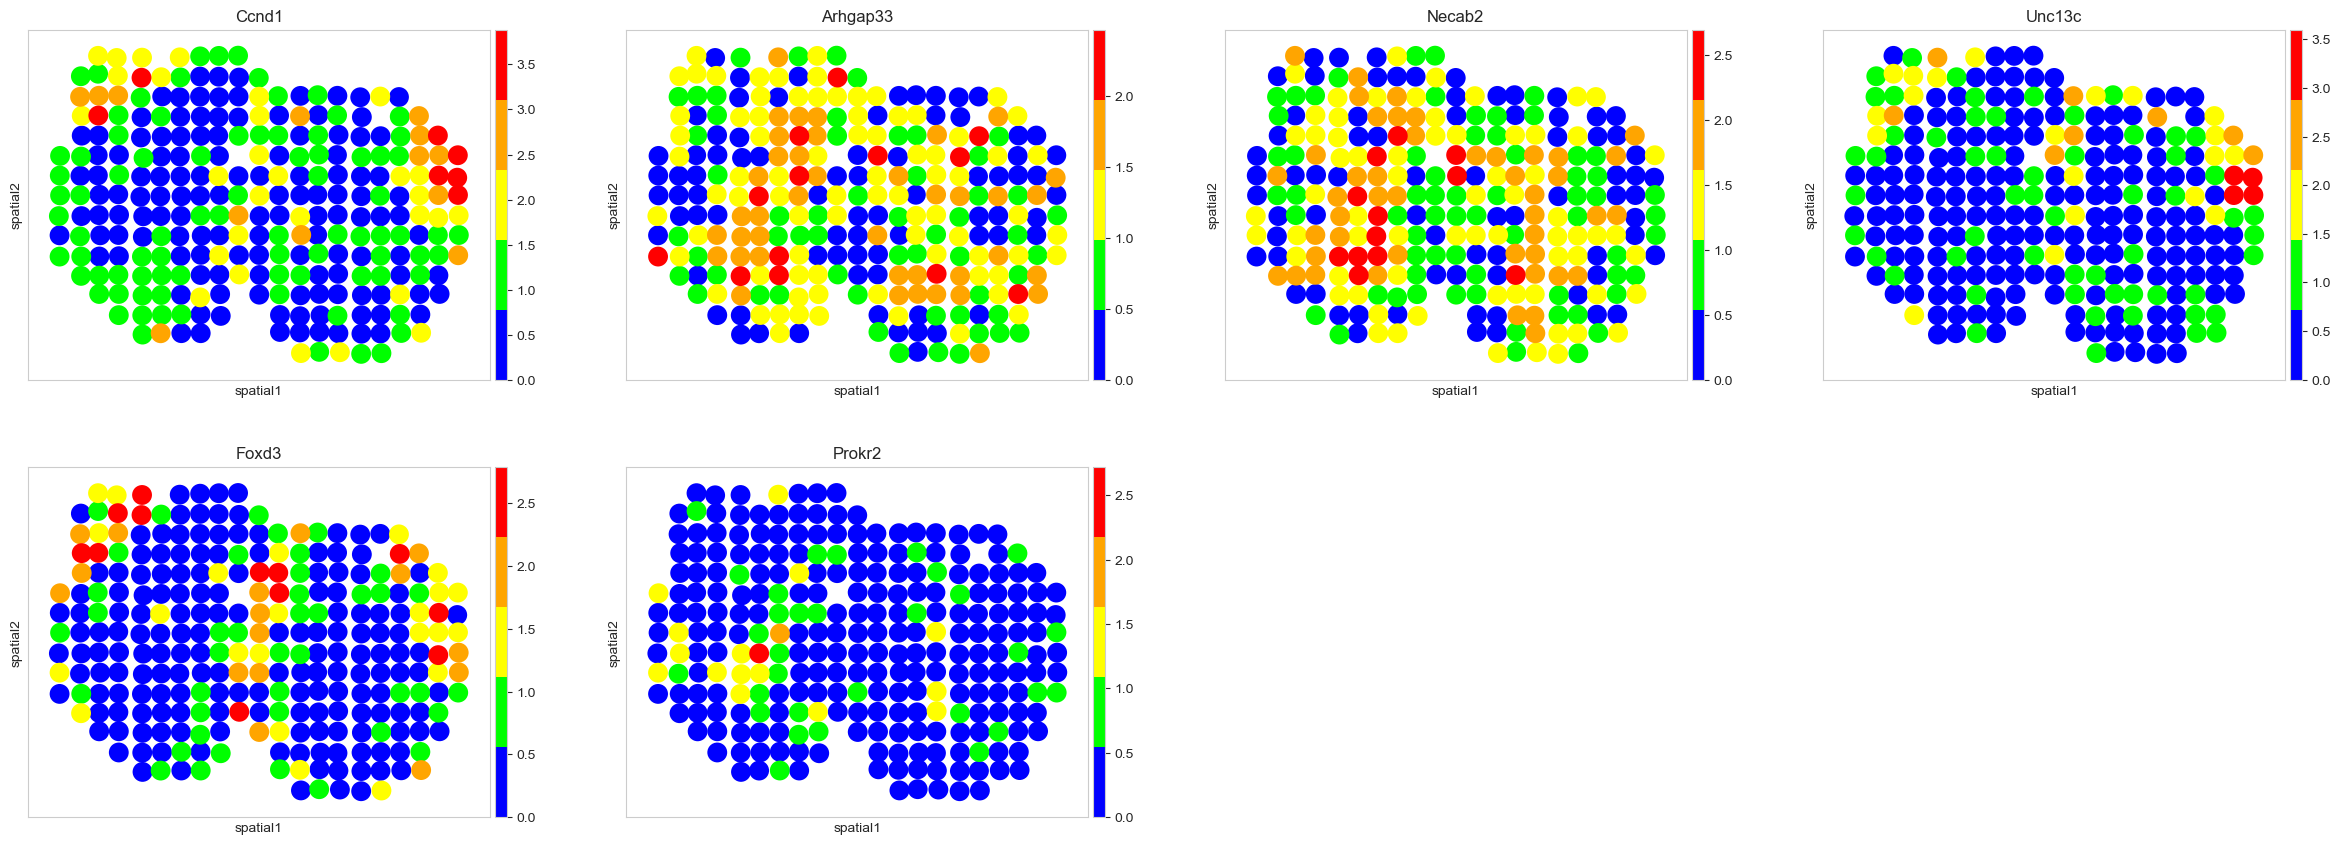

In [51]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

new_colors = ['#0000FF',  '#00FF00','#FFFF00', '#FFA500', '#FF0000']
new_cmap = mcolors.ListedColormap(new_colors)
sc.pl.spatial(adata,
              size=2,
              spot_size=.5,
              cmap=new_cmap,
              color=list(result[result['labels'] == 4]['gene_id']))

In [1]:
view_gmm(gmm_dict['Mbp'], scope=(0, max(adata.obs['y'].max(), adata.obs['x'].max())), bin_count=100)


NameError: name 'view_gmm' is not defined

In [12]:
gmm = fit_gmm(adata, 'Mbp',n_comp=20, top_components=5)

KeyboardInterrupt: 

In [52]:
view_gmm(gmm_dict['Doc2g'], scope=(0, max(adata.obs['y'].max(), adata.obs['x'].max())), bin_count=100)

AttributeError: 'GMM' object has no attribute 'score_samples'

<AxesSubplot:xlabel='labels', ylabel='Count'>

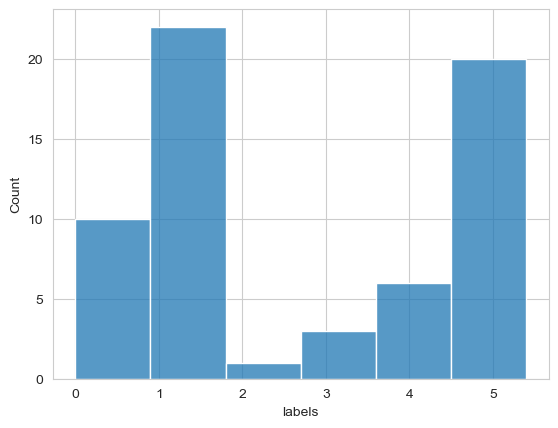

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(result['labels'],binwidth=.9)

In [10]:
import anndata
from Algorithm.distribution import GMM

def fit_gmm(adata: anndata,
            gene_name: str,
            n_comp: int = 10,
            max_iter: int = 200,
            top_components: int = 5
            ):
    """
    Representation of a Gaussian mixture model probability distribution.
    Estimate the parameters of a Gaussian mixture distribution.

    Estimate model parameters with the EM algorithm.
    :param top_components:
    :type top_components:
    :param adata: Anndata of spatial data
    :type adata: Anndata
    :param gene_name: The gene name to fit
    :type gene_name: str
    :param n_comp: The number of mixture components.
    :type n_comp: int
    :param max_iter: The number of EM iterations to perform.
    :type max_iter: int
    :return: The fitted mixture.
    :rtype: GaussianMixture
    """
    dense_array = get_exp_array(adata, gene_name)
    result = array_to_list(dense_array)
    # Number of unique center must be larger than the number of components.
    if len(set(map(tuple, result))) > n_comp:
        gmm = mixture.GaussianMixture(n_components=n_comp, max_iter=max_iter)
        gmm.fit(result)
        indices = list(np.argsort(gmm.weights_)[-top_components:])
        means = []
        covs = []
        new_gmm = GMM(5)
        for index in indices:
            means.append(gmm.means_[index])
            covs.append(gmm.covariances_[index])
        new_gmm.set_mean(np.array(means))
        new_gmm.set_covariances(np.array(covs))
        return new_gmm
    else:
        return None

gmm = fit_gmm(adata, 'Mbp' ,n_comp=20,top_components=5)